In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
import missingno as msno
import os
import wget
import openpyxl
import math
import fiona
from census import Census
import us 
from scipy.stats import linregress
import scipy.stats as st
# Import U.S. Census API Key
from config import api_key

In [30]:
#wget.download("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip") GET SHAPEFILE

shapefile = fiona.open("cb_2018_us_state_500k/cb_2018_us_state_500k.shp")
shapefile_df = pd.DataFrame(shapefile)
#create key
shapefile_df['state_code'] = shapefile_df['id'].astype(int)
shapefile_df.head()

,geometry,id,properties,state_code
0,"[coordinates, type, geometries]",0,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA...",0
1,"[coordinates, type, geometries]",1,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA...",1
2,"[coordinates, type, geometries]",2,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA...",2
3,"[coordinates, type, geometries]",3,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA...",3
4,"[coordinates, type, geometries]",4,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA...",4


In [27]:
#GET STATE ONLY INFO FROM CENSUS

years = [2017,2018,2019,2020,2021]

for year in years:

    c = Census(
    api_key,
    year = year
              )
    
    census_data = c.acs5.get(
        (
            "NAME",
            "B19013_001E", #pop 
            "B01003_001E", #median age
            "B01002_001E", #household income
            "B19301_001E", #Per capital income
            "B17001_002E", #poverty count
            "B23022_001E", #total work force
            "B23001_088E", #total female workforce
            "B23022_049E", #total female did not work
            "B23022_002E", #total male workforce
            "B23022_025E", #total male did not work
            "B15003_023E", # masters degrees
            "B25058_001E", #median rent

            
        ), {'for': 'state:*'}
    )


# # Convert to DataFrame, add the year of the census data, concatenate dfs together
    if year == years[0]:
        census_pd = pd.DataFrame(census_data)
        census_pd['Year'] = year
        census_pd_combined = census_pd
    else:
        census_pd = pd.DataFrame(census_data)
        census_pd['Year'] = year
        census_pd_combined = pd.concat([census_pd,census_pd_combined])

#Column renaming
census_pd_combined = census_pd_combined.rename(
    columns = {
        "NAME":        "Name",
        "B01003_001E": "Population",
        "B01002_001E": "Median Age",
        "B19013_001E": "Household Income",
        "B19301_001E": "Per Capita Income",
        "B17001_002E": "Poverty Count",
        "B23022_001E": "Total Work Force",
        "B23001_088E": "Total Female Workforce",
        "B23022_049E": "Total Female Did Not Work",
        "B23022_002E": "Total Male Workforce",
        "B23022_025E": "Total Male Did Not Work",
        "B15003_023E": "Masters Attainment",
        "B25058_001E": "Median Rent"
        
    }
        )


In [32]:
#Merge Datasets

#create key
census_pd_combined['state_code'] = census_pd_combined['state'].astype(int)
census_pd_combined.head()

#merge
census_pd_combined_shape = pd.merge(census_pd_combined, shapefile_df, how = 'left', on='state_code')
census_pd_combined_shape.head()

,Name,Household Income,Population,Median Age,Per Capita Income,Poverty Count,Total Work Force,Total Female Workforce,Total Female Did Not Work,Total Male Workforce,Total Male Did Not Work,Masters Attainment,Median Rent,state,Year,state_code,geometry,id,properties
0,Alabama,54943.0,4997675.0,39.3,30458.0,769819.0,3161072.0,2083785.0,524779.0,1549575.0,371362.0,251040.0,630.0,01,2021,1,"[coordinates, type, geometries]",1,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA..."
1,Alaska,80287.0,735951.0,35.0,39236.0,75016.0,481977.0,271261.0,54983.0,255877.0,43700.0,39503.0,1153.0,02,2021,2,"[coordinates, type, geometries]",2,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA..."
2,Arizona,65913.0,7079203.0,38.1,34644.0,934911.0,4406765.0,2846006.0,634233.0,2227680.0,444809.0,413353.0,994.0,04,2021,4,"[coordinates, type, geometries]",4,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA..."
3,Arkansas,52123.0,3006309.0,38.3,29210.0,468113.0,1876894.0,1219539.0,287362.0,935991.0,232365.0,129009.0,612.0,05,2021,5,"[coordinates, type, geometries]",5,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA..."
4,California,84097.0,39455353.0,37.0,41276.0,4741175.0,25829825.0,15857294.0,3798202.0,13092884.0,2633897.0,2449563.0,1547.0,06,2021,6,"[coordinates, type, geometries]",6,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA..."


In [35]:
# Add a Male Did Not Work Rate, Female Did Not Work Rate, Delta
census_pd_combined_shape["Male DNW %"] = 100 * census_pd_combined_shape["Total Male Did Not Work"] / census_pd_combined_shape["Total Male Workforce"]
census_pd_combined_shape["Female DNW %"] = 100 * census_pd_combined_shape["Total Female Did Not Work"] / census_pd_combined_shape["Total Female Workforce"]
census_pd_combined_shape['DNW Delta'] = census_pd_combined_shape['Female DNW %']-census_pd_combined_shape['Male DNW %']
census_pd_combined_shape['Poverty Rate'] = 100 * census_pd_combined_shape["Poverty Count"] / census_pd_combined_shape["Population"]

# Display DataFrame length and sample data

print(f"Number of rows in the DataFrame: {len(census_pd_combined_shape)}")
census_pd_combined_shape.head()


Number of rows in the DataFrame: 260


,Name,Household Income,Population,Median Age,Per Capita Income,Poverty Count,Total Work Force,Total Female Workforce,Total Female Did Not Work,Total Male Workforce,...,state,Year,state_code,geometry,id,properties,Male DNW %,Female DNW %,DNW Delta,Poverty Rate
0,Alabama,54943.0,4997675.0,39.3,30458.0,769819.0,3161072.0,2083785.0,524779.0,1549575.0,...,01,2021,1,"[coordinates, type, geometries]",1,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA...",23.965410,25.183932,1.218522,15.403543
1,Alaska,80287.0,735951.0,35.0,39236.0,75016.0,481977.0,271261.0,54983.0,255877.0,...,02,2021,2,"[coordinates, type, geometries]",2,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA...",17.078518,20.269408,3.190890,10.193070
2,Arizona,65913.0,7079203.0,38.1,34644.0,934911.0,4406765.0,2846006.0,634233.0,2227680.0,...,04,2021,4,"[coordinates, type, geometries]",4,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA...",19.967365,22.285020,2.317655,13.206444
3,Arkansas,52123.0,3006309.0,38.3,29210.0,468113.0,1876894.0,1219539.0,287362.0,935991.0,...,05,2021,5,"[coordinates, type, geometries]",5,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA...",24.825559,23.563166,-1.262393,15.571021
4,California,84097.0,39455353.0,37.0,41276.0,4741175.0,25829825.0,15857294.0,3798202.0,13092884.0,...,06,2021,6,"[coordinates, type, geometries]",6,"[STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NA...",20.117012,23.952397,3.835385,12.016557


In [37]:
#census_pd_combined_shape.to_csv("census_data_states.csv", encoding="utf-8", index=False)

<Axes: >

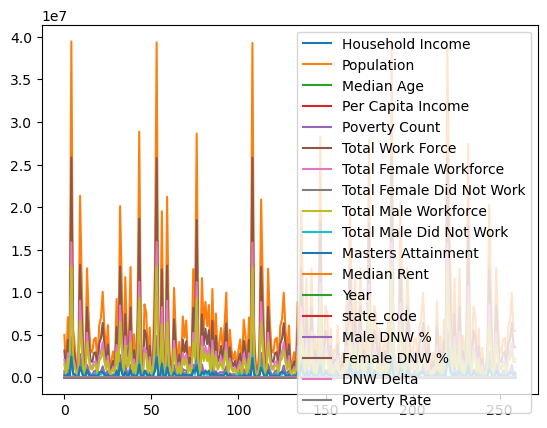

In [38]:
census_pd_combined_shape.plot()